# Basketball Analytics: Predicting Win Shares

## Analysis

**Objective: Can we predict individual win shares of NBA players using other basketball metrics?**

The data used for this analysis is from the 2016–17 and 2017–2018 NBA Season, using Basketball-Reference. Essentially, I used data from the 2016–2017 NBA season to create our model and stats from the most recent season to predict win shares. I performed a supervised regression machine learning analysis.

Today, there are plenty of new basketball metrics used by fans and analysts worldwide to compare and measure players. In order to predict Win Shares, I used a mix of basic and advanced NBA stats:

In [1]:
# All the packages we will be using

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn import neighbors
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from operator import itemgetter
plt.style.use('fivethirtyeight')

In [2]:
# Import 2017 & 2018 NBA stats datasets

stats_2017 = pd.read_csv('C:/Users/osanchez/Downloads/2017_season(1).csv')
stats_2018 = pd.read_csv('C:/Users/osanchez/Downloads/2018_season(1).csv')


stats_2017 = stats_2017[['Player', 'Pos_x','G_x','MP_x','PS/G','AST','TRB','3P%','FG%','FT%','eFG%','VORP','TS%','BPM','PER','WS']]
stats_2018 = stats_2018[['Player', 'Pos_x','G_x','MP_x','PS/G','AST','TRB','3P%','FG%','FT%','eFG%','VORP','TS%','BPM','PER','WS']]

stats_2017.columns = ['Player', 'Pos','G','MP','PS/G','AST','TRB','3P%','FG%','FT%','eFG%','VORP','TS%','BPM','PER','WS']
stats_2018.columns = ['Player', 'Pos','G','MP','PS/G','AST','TRB','3P%','FG%','FT%','eFG%','VORP','TS%','BPM','PER','WS']


ws_2018 = stats_2018[['Player', 'WS']]

### Exploratory Data Analysis
**What did the distribution of win shares originally look like?**

Before continuing the analysis, I used basic EDA to see what our data can tell us first hand. First, I took a quick look at the distribution win shares:

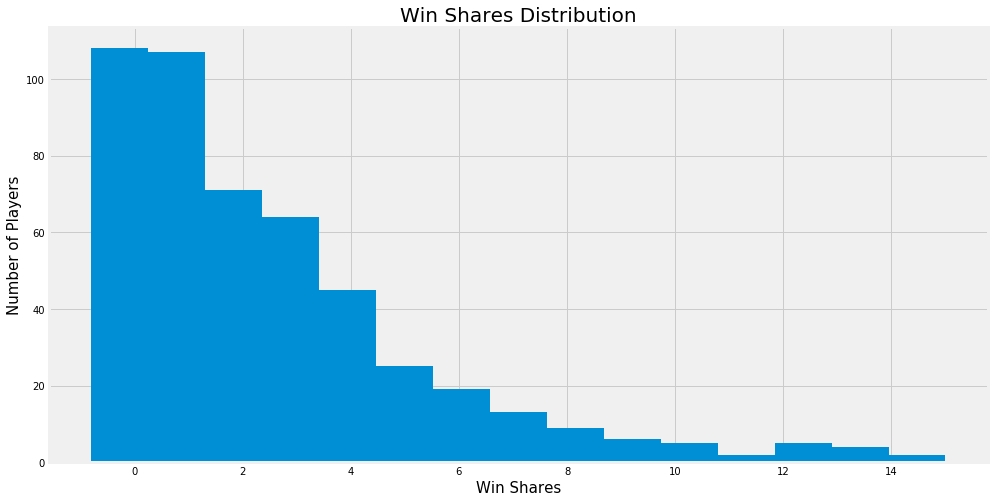

In [3]:
plt.figure(figsize = (15,8))
plt.hist(stats_2017['WS'], bins = 15)
plt.xlabel('Win Shares', size = 15)
plt.ylabel('Number of Players', size = 15)
plt.title('Win Shares Distribution', size = 20);

Right away, we see that the distribution of win shares is skewed to the right. The majority of NBA players during the 2016–2017 NBA season had a win share of less than 5. This makes sense since only a selected few, mostly composed of NBA All Stars, will have very high win shares. For example, the win shares leader of the 2016–2017 NBA season was James Harden,the runner-up for MVP,  with 15 win shares. So, it's an elite status to have a high win shares.

The odd takeaway from the distribution is the number of players with 0 win shares. After further analysis, I was able to find that there was a high number of players that barely played at all. Although these players are on NBA rosters, that doesn't mean they will not have significant impact to both the team and their own individual stats. Therefore, I updated the data to only include players that had played at least 30 games and averaged at least 25 minutes of playing time per game. Here's what the distribution of win shares looks like after cleaning out the data:

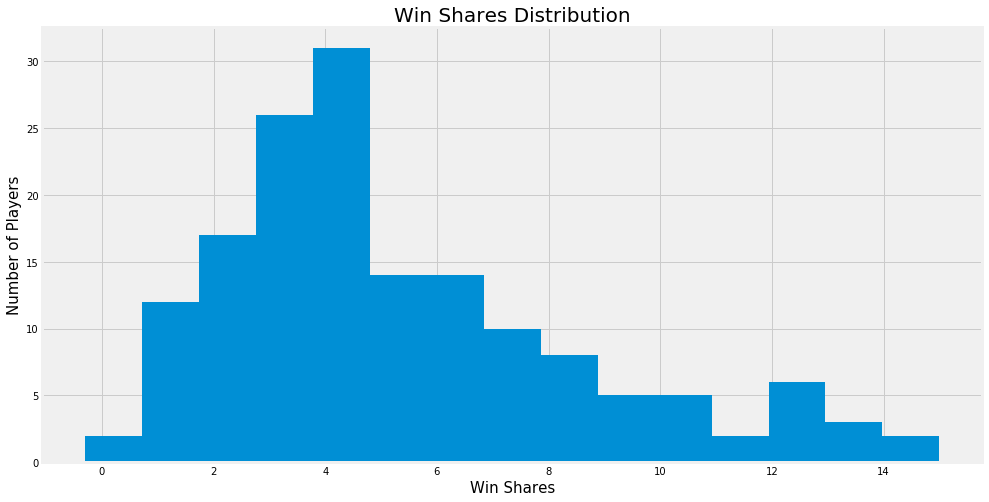

In [4]:
stats_2017 = stats_2017[stats_2017['G'] > 30]
stats_2018 = stats_2018[stats_2018['G'] > 30]

stats_2017 = stats_2017[stats_2017['MP'] > 25]
stats_2018 = stats_2018[stats_2018['MP'] > 25]

plt.figure(figsize = (15,8))
plt.hist(stats_2017['WS'], bins = 15)
plt.xlabel('Win Shares', size = 15)
plt.ylabel('Number of Players', size = 15)
plt.title('Win Shares Distribution', size = 20);

There's a lot less players with 0 win shares now! The distribution of win shares is still skewed to the right, but looks a bit more normally distributed. 

**Were all the features I chose good predictors of win shares?**

I analyzed this question by using the Pearson Correlation Coefficient, which measures the linear correlation between the features and target (win shares). It has a value between -1 and +1, where a value close to -1 represents a negatively strong relationship and a value close to +1 represents a positively strong relationship:

In [5]:
# Correlation between Win Shares and features

corr_2017 = stats_2017.corr()['WS'].reset_index()
corr_2017 = corr_2017.sort_values([('WS')], ascending = False)
corr_2017

,index,WS
13,WS,1.000000
9,VORP,0.884468
12,PER,0.859586
11,BPM,0.854237
10,TS%,0.680769
2,PS/G,0.659645
1,MP,0.637278
4,TRB,0.526051
6,FG%,0.525109
8,eFG%,0.506630


This discovery was surprising! Of the 13 basketball metrics I originally chose to predict win shares, 4 of them did not have a strong enough correlation (strong = greater than 0.5 & less than -0.5). Therefore, I excluded those metrics from my model. 

I was stunned to see 3-Point percentage (3P%) have not only a weak correlation, but also a negative correlation. In today's NBA, almost every team and player relies heavily on the 3P, so I assumed 3P% would play an important part in the analysis. Another interesting finding was the weak relationship between games played (G) and win shares. One would assume that the more games a player is involved in, the higher their win shares would be. However, just because a player is involved in a game, doesn't mean they will have success. Assists (AST) was another metric that I assumed would have a strong relationship with win shares.

**Were the remaining features highly correlation with one another?**

For the next part of the analysis, I wanted to see whether the features were strongly correlated with one another, or multicollinearity. Multicollinearity generally occurs when there are high correlations between two or more predictor variables. Remember, features having a strong correlation with win shares is good, but features being strongly correlated with other features might not be that helpful. It can even make it tougher to interpret the models we will be creating.

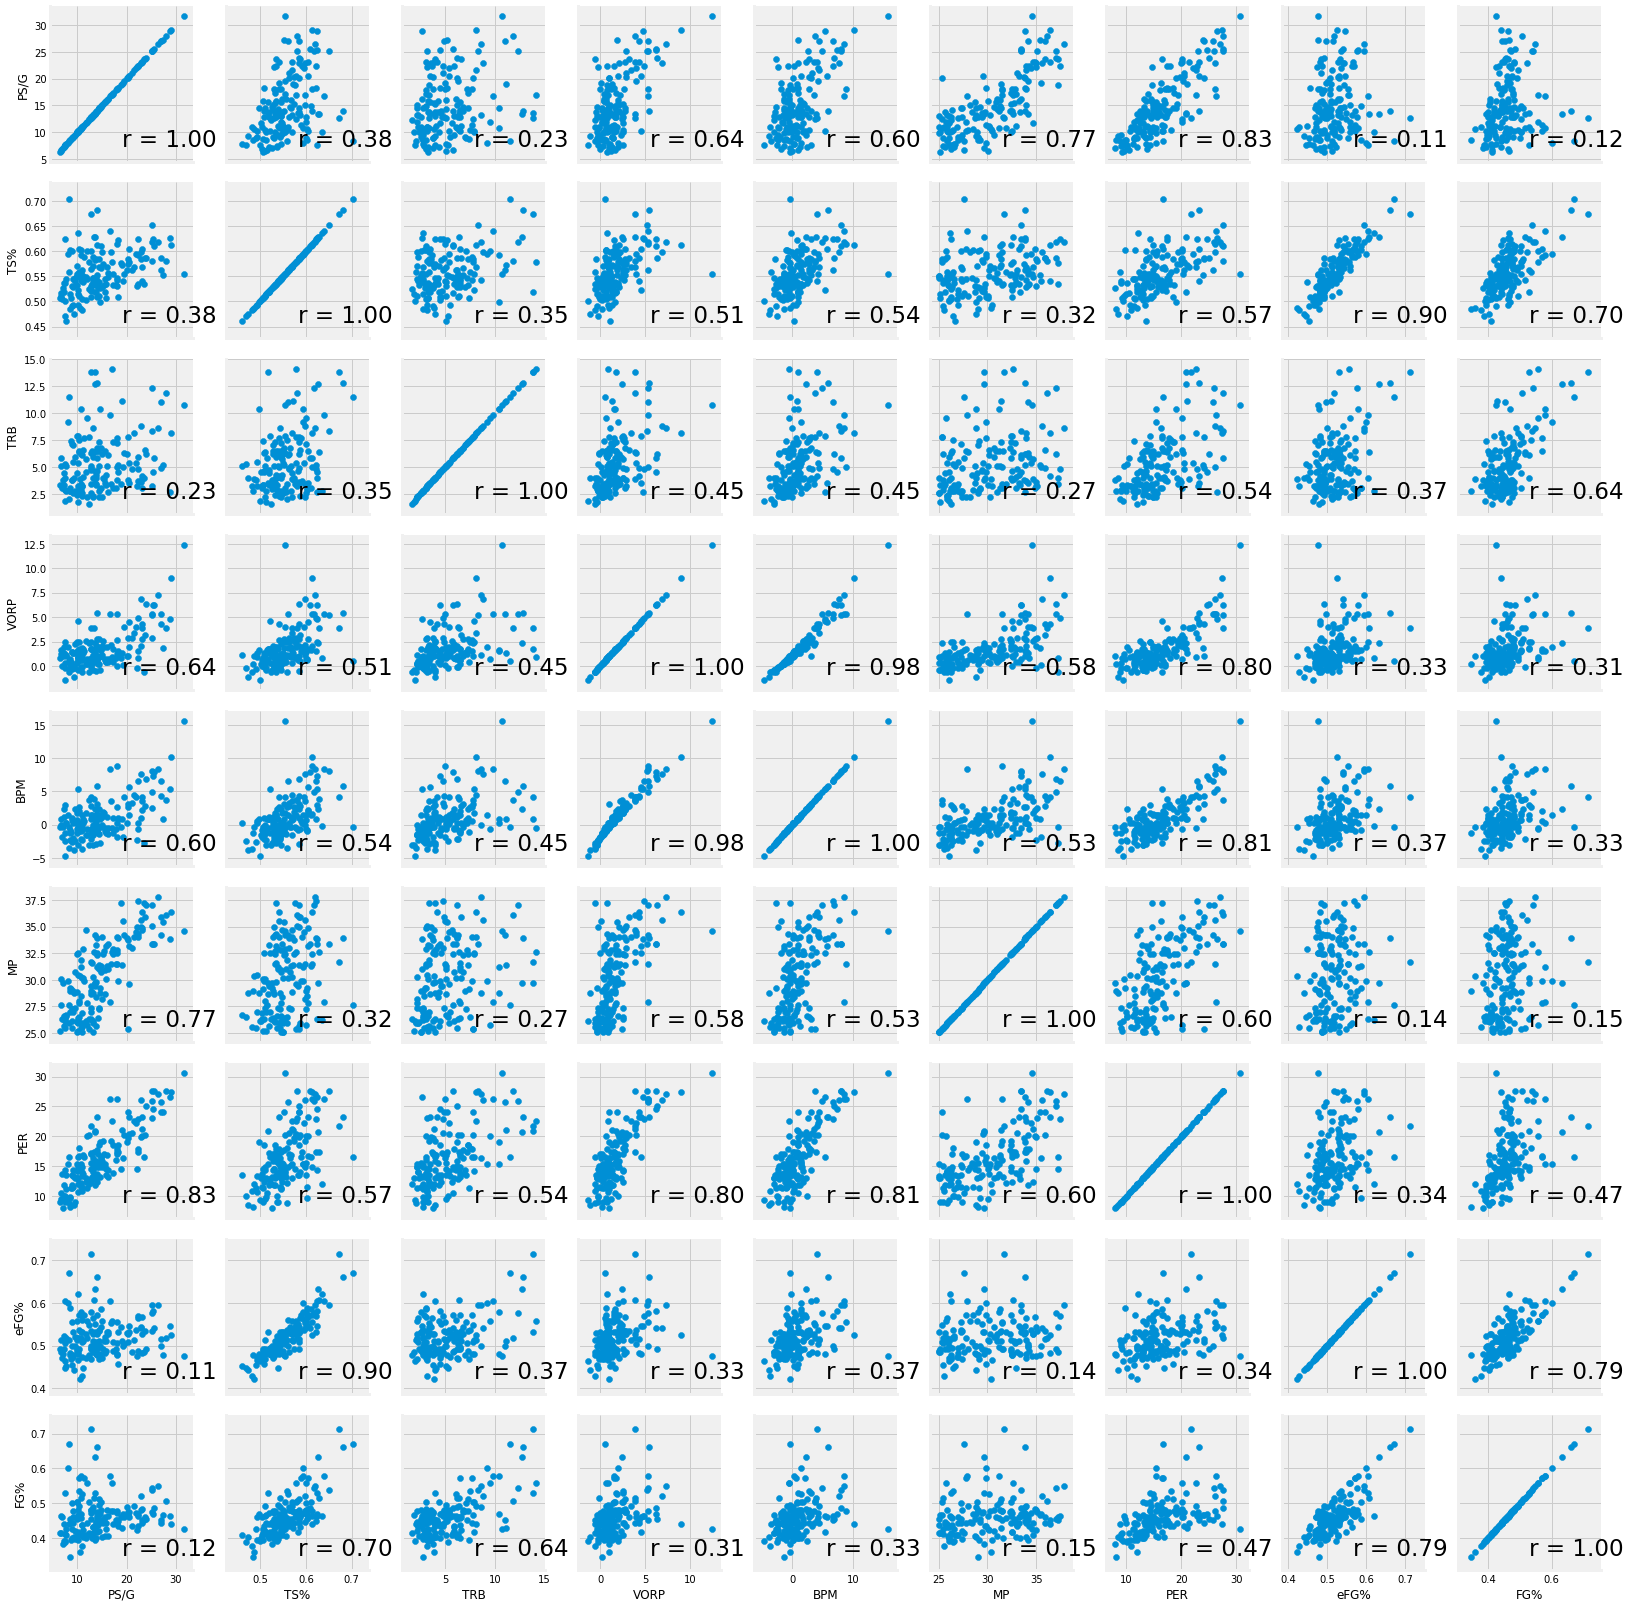

In [6]:
stats_2017_corr = stats_2017[['Player','Pos','PS/G','TS%','TRB','VORP','BPM','MP','PER','eFG%','FG%']]


def feature_corr(x, y, **kwargs):
    cor = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(cor),
                xy=(.5, .1),
                xycoords=ax.transAxes,
                size = 23)


plots = sb.PairGrid(stats_2017_corr)
plots.map(plt.scatter)
plots.map(feature_corr);

Based on the PairPlot above, I found some issues between the features:

-  VORP vs BPM: has a very strong positive relationship (correlation of 0.98). Box Plus Minus (BPM) is a player's contribution per 100 possesions over the league average when the player was on the court. Value Over Replacement Player (VORP) takes BPM and translates it into minutes based contribution to a team. In order to calculate VORP, you need to use BPM. Therefore, they are highly correlated.

-  Shooting Percentage Metrics: We had three shooting percentage metrics left in the analysis. Field goal percentage (FG%) is a ratio of field goals made to field goals attempted. Effective field goal percentage (eFG%) adjusts field goal percentage to account for the fact that three-point field goals count for three points while field goals only count for two points. True shooting percentage (TS%) measures a player's shooting efficiency by calculating two- and three-point field goals and free throws. I felt that these metrics were closely related (TS% and eFG% had a correlation of 0.90). Therefore, I decided to only use TS% since it had the highest correlation with win shares.

### Model Selection and Testing
Since this was a supervised regression machine learning analysis, I created three regression models:
-  Linear Regression
-  Support Vector Regression
-  k-Nearest Neighbors Regression

In [7]:
# Create the train test datasets

train, test = train_test_split(stats_2017, test_size=0.25, random_state=99)

x_train = train[['PS/G','TS%','TRB','VORP','PER','MP']]
y_train = train[['WS']]

x_test = test[['PS/G','TS%','TRB','VORP','PER','MP']]
y_test = test[['WS']]

In [8]:
# Create the Linear Regression model

linReg = linear_model.LinearRegression()
linReg.fit(x_train, y_train)

linReg.predict(x_test)

y_lin_pred = linReg.predict(x_test)

print('Score: %.3f' % linReg.score(x_train, y_train))
print('Mean squared error: %.3f' % mean_squared_error(y_test, y_lin_pred))
print('Mean Absolute error: %.3f' % mean_absolute_error(y_test, y_lin_pred))
print('Variance score: %.3f' % r2_score(y_test, y_lin_pred))

Score: 0.910
Mean squared error: 1.007
Mean Absolute error: 0.761
Variance score: 0.880


In [9]:
# Create the Support Vector Regression model

svr = SVR(kernel='rbf', gamma=1e-3, C=150, epsilon=0.3)
svr.fit(x_train, y_train.values.ravel())

y_svr_pred = svr.predict(x_test)

print('Score: %.3f' % svr.score(x_train, y_train))
print("Mean squared error: %.3f" % mean_squared_error(y_test, y_svr_pred))
print('Mean Absolute error: %.3f' % mean_absolute_error(y_test, y_svr_pred))
print('Variance score: %.3f' % r2_score(y_test, y_svr_pred))

Score: 0.936
Mean squared error: 1.562
Mean Absolute error: 1.038
Variance score: 0.814


In [10]:
# Create the k-Nearest Neighbors Regression Model

knn = neighbors.KNeighborsRegressor(n_neighbors = 7, weights = 'uniform')
knn.fit(x_train, y_train)

y_knn = knn.predict(x_test)

print('Score: %.3f' % knn.score(x_train, y_train))
print("Mean Squared Error: %.3f" % mean_squared_error(y_test, y_knn))
print('Mean Absolute error: %.3f' % mean_absolute_error(y_test, y_knn))
print('Variance Score: %.3f' % r2_score(y_test, y_knn))

Score: 0.823
Mean Squared Error: 2.132
Mean Absolute error: 1.215
Variance Score: 0.747


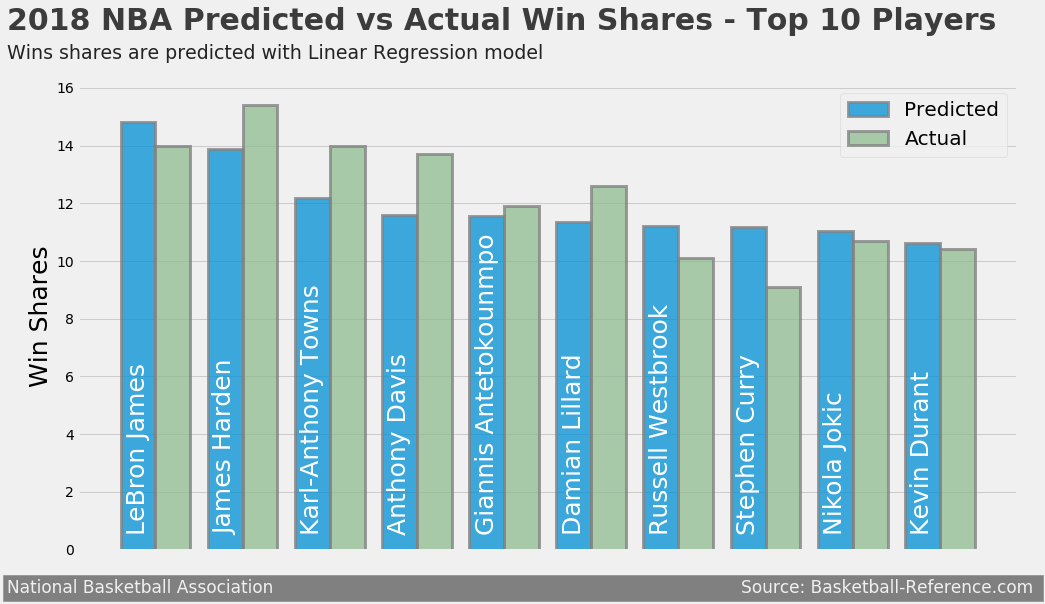

In [11]:
# Predict Win Shares using Linear Regression Model

lin_new = stats_2018[['PS/G','TS%','TRB','VORP','PER','MP']]

lin_pred_2018 = linReg.predict(lin_new)

lin_names = stats_2018.iloc[:, 0]
a = []
for i, j in zip(lin_pred_2018, lin_names):
    a.append({'WS_pred':i,'Player':j})

lin_wins = pd.DataFrame(a)
lin_wins['WS_pred'] = round(lin_wins['WS_pred'].astype(float),2)

lin_wins = lin_wins.sort_values([('WS_pred')], ascending = False).reset_index(drop=True).head(10)
lin_wins = lin_wins.merge(ws_2018, on = 'Player', how = 'inner')


pos = np.arange(len(lin_wins['WS_pred']))

plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize = (15,8))
plt.bar(pos, lin_wins['WS_pred'], width = 0.4, alpha = 0.75, edgecolor = 'gray', linewidth = 3, label = 'Predicted')
plt.bar(pos + .4, lin_wins['WS'], width = 0.4, alpha = 0.75, edgecolor = 'gray', linewidth = 3, label = 'Actual',color = 'darkseagreen')
for i in pos:
    plt.text(pos[i], 0.5, s = lin_wins['Player'][i],ha='center', va='bottom', rotation = 'vertical',color = 'white', size = 25)
plt.text(x = -1.5, y = 18, s = '2018 NBA Predicted vs Actual Win Shares - Top 10 Players',fontsize = 30, weight = 'bold', alpha = .75)
plt.text(x = -1.5, y = 17, s = 'Wins shares are predicted with Linear Regression model',fontsize = 19, alpha = .85)
plt.text(x = -1.5, y = -1.5, s = 'National Basketball Association                                                                                       Source: Basketball-Reference.com ', fontsize = 17,color = '#f0f0f0', backgroundcolor = 'grey')
plt.xticks([],[])
plt.legend(prop={'size': 20})
ax.set_ylabel('Win Shares', size = 25);

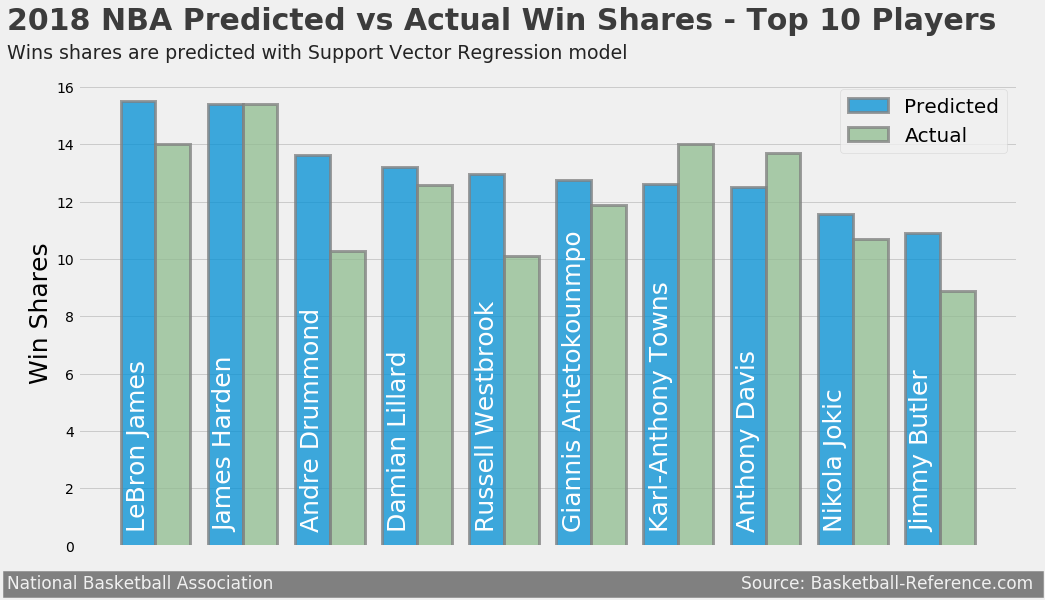

In [12]:
# Predict Win Shares using Support Vector Regression Model

svr_new = stats_2018[['PS/G','TS%','TRB','VORP','PER','MP']]

svr_pred_2018 = svr.predict(svr_new)

svr_names = stats_2018.iloc[:, 0]

b = []
for i, j in zip(svr_pred_2018, svr_names):
    b.append({'WS_pred':i,'Player':j})


svr_wins = pd.DataFrame(b)
svr_wins['WS_pred'] = round(svr_wins['WS_pred'].astype(float),2)

svr_wins = svr_wins.sort_values([('WS_pred')], ascending = False).reset_index(drop=True).head(10)
svr_wins = svr_wins.merge(ws_2018, on = 'Player', how = 'inner')

pos = np.arange(len(svr_wins['WS_pred']))

plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize = (15,8))
plt.bar(pos, svr_wins['WS_pred'], width = 0.4, alpha = 0.75, edgecolor = 'gray', linewidth = 3, label = 'Predicted')
plt.bar(pos + 0.4, svr_wins['WS'], width = 0.4, alpha = 0.75, edgecolor = 'gray', linewidth = 3,label = 'Actual',color = 'darkseagreen')
for i in pos:
    plt.text(pos[i], 0.5, s = svr_wins['Player'][i],ha='center', va='bottom', rotation = 'vertical',color = 'white', size = 25)
plt.text(x = -1.5, y = 18, s = '2018 NBA Predicted vs Actual Win Shares - Top 10 Players',fontsize = 30, weight = 'bold', alpha = .75)
plt.text(x = -1.5, y = 17, s = 'Wins shares are predicted with Support Vector Regression model',fontsize = 19, alpha = .85)
plt.text(x = -1.5, y = -1.5, s = 'National Basketball Association                                                                                       Source: Basketball-Reference.com ', fontsize = 17,color = '#f0f0f0', backgroundcolor = 'grey')
plt.xticks([],[])
plt.legend(prop={'size': 20})
ax.set_ylabel('Win Shares', size = 25);

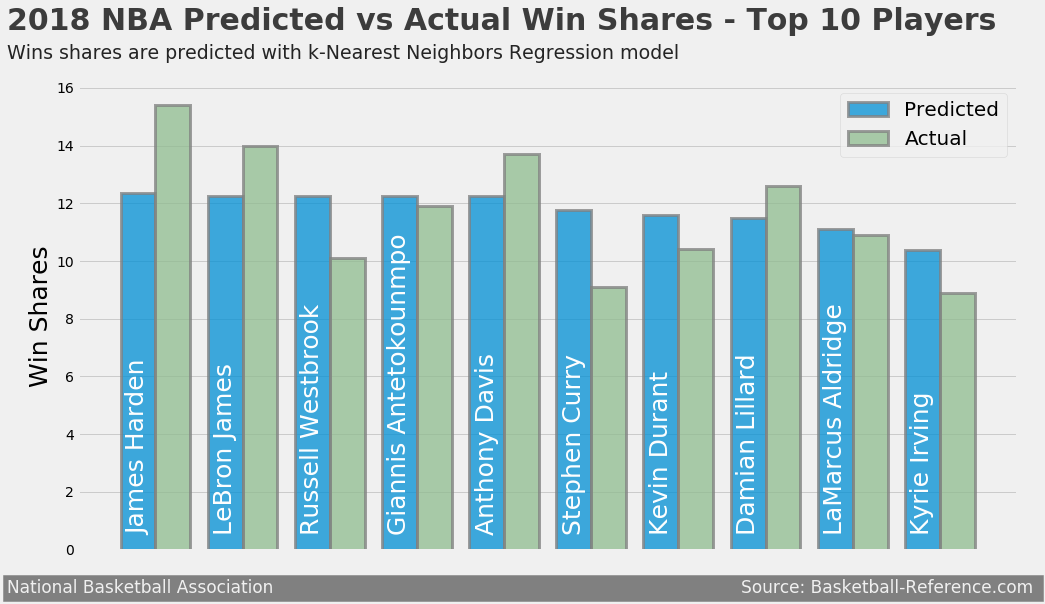

In [13]:
# Predict Win Shares using k-Nearest Neighbors Regression Model

knn_new = stats_2018[['PS/G','TS%','TRB','VORP','PER','MP']]

knn_pred_2018 = knn.predict(svr_new)

knn_names = stats_2018.iloc[:, 0]

c = []
for i, j in zip(knn_pred_2018, knn_names):
    c.append({'WS_pred':i,'Player':j})


knn_wins = pd.DataFrame(c)
knn_wins['WS_pred'] = round(knn_wins['WS_pred'].astype(float),2)

knn_wins = knn_wins.sort_values([('WS_pred')], ascending = False).reset_index(drop=True).head(10)
knn_wins = knn_wins.merge(ws_2018, on = 'Player', how = 'inner')


pos = np.arange(len(knn_wins['WS_pred']))

plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize = (15,8))
plt.bar(pos, knn_wins['WS_pred'], width = 0.4, alpha = 0.75, edgecolor = 'gray', linewidth = 3, label = 'Predicted')
plt.bar(pos + 0.4, knn_wins['WS'], width = 0.4, alpha = 0.75, edgecolor = 'gray', linewidth = 3,label = 'Actual',color = 'darkseagreen')
for i in pos:
    plt.text(pos[i], 0.5, s = knn_wins['Player'][i],ha='center', va='bottom', rotation = 'vertical',color = 'white', size = 25)
plt.text(x = -1.5, y = 18, s = '2018 NBA Predicted vs Actual Win Shares - Top 10 Players',fontsize = 30, weight = 'bold', alpha = .75)
plt.text(x = -1.5, y = 17, s = 'Wins shares are predicted with k-Nearest Neighbors Regression model',fontsize = 19, alpha = .85)
plt.text(x = -1.5, y = -1.5, s = 'National Basketball Association                                                                                       Source: Basketball-Reference.com ', fontsize = 17,color = '#f0f0f0', backgroundcolor = 'grey')
plt.xticks([],[])
plt.legend(prop={'size': 20})
ax.set_ylabel('Win Shares', size = 25);